In [1]:
import os
import tensorflow as tf
import numpy as np
import PIL
import matplotlib.pyplot as plt
from pathlib import Path

2022-03-30 10:52:30.262868: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-30 10:52:30.262885: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


First, let's see the max number of tactile surfaces occur in a photo. This will define the size of the output vector because it will be the max number times 4 (for each bounding box coordinate) plus 1 (for number of bounding boxes in image).

In [3]:
max_annotations = 0

for image_label in os.listdir("../../data/trainval/label"):
    with open(os.path.join("../../data/trainval/label", image_label), "r") as f:
        for i, line in enumerate(f.readlines()):
            if i+1 > max_annotations:
                max_annotations = i+1

print(max_annotations)

4


In [4]:
max_image_width = 0
max_image_height = 0

for image_label in os.listdir("../../data/trainval/image"):
    if image_label.startswith("custom"):
        print(image_label)
        continue
    else:
        with PIL.Image.open(os.path.join("../../data/trainval/image", image_label)) as img:
            array = np.array(img)
            img.close()
        if array.shape[0] > max_image_width:
            max_image_width = array.shape[0]

        if array.shape[1] > max_image_height:
            max_image_height = array.shape[1]

print(max_image_width, max_image_height)

custom_train.json
768 1024


Sort files so they can be read sequentially

In [5]:
data_path = "../../data/trainval"
path = Path(data_path)

img_paths = sorted(map(str, (path / "image").glob('*.jpg')))
label_paths = sorted(map(str, (path / "label").glob('*.txt')))

Create list dataset for the images. This creates a tensor of all the image filenames.

In [6]:
list_ds = tf.data.Dataset.list_files(
    img_paths, 
    shuffle=False
    )

2022-03-30 10:53:32.791329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 10:53:32.791785: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-30 10:53:32.791880: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-30 10:53:32.791975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-30 10:53:32.792035: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [7]:
next(iter(list_ds))

<tf.Tensor: shape=(), dtype=string, numpy=b'../../data/trainval/image/-0TOaI88FaLVsYj2ekEoCA.jpg'>

Now, we need to resize the images so that they are all the same size. The method I am choosing is to find the largest image size and pad the rest with zeros. This way, it is easy to convert the bounding box coordinates to the correct coordinates on the padded image. Given an image, point coordinates $(x, y)$, and a padding distances $P_W, P_H$, the new coordinates are found by: 
$$
x \prime = x + \frac{P_W}{2}
\newline{}
\newline{}
y \prime = y + \frac{P_H}{2}
$$

In [8]:
def parse_and_pad_image(filename: str) -> tf.Tensor:
    """Converts image path to a tensor, padded with zeros to the maximum image size in the dataset"""
    max_image_width = 1024
    max_image_height = 768

    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize_with_pad( # problem: half of this padding needs
    # to be added to the x, y coords for the bounding boxes
        image, 
        target_height=max_image_height, 
        target_width=max_image_width
        )
    # image = tf.image.convert_image_dtype(image, tf.uint8)
    return image

In [9]:
def parse_image(filename):
    """Converts image path to a tensor"""
    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image, channels=3)
    return image

In [10]:
def get_pad_dims(ds, padded_ds):
    """Gets difference between sizes of padded image and non-padded image"""
    h_pad_dims = []
    w_pad_dims = []

    for image, padded_image in zip(ds.take(-1), padded_ds.take(-1)):
        h_pad_dims.append(padded_image.shape[0] - image.shape[0])
        w_pad_dims.append(padded_image.shape[1] - image.shape[1])

    return h_pad_dims, w_pad_dims

In [11]:
not_padded_ds = list_ds.map(parse_image)

In [12]:
images_ds = list_ds.map(parse_and_pad_image)

for image in images_ds.take(1):
    print(tf.reduce_max(image), "\n", tf.reduce_min(image))
    print("\n", image.shape)

tf.Tensor(255.0, shape=(), dtype=float32) 
 tf.Tensor(0.0, shape=(), dtype=float32)

 (768, 1024, 3)


In [13]:
h_pad, w_pad = get_pad_dims(not_padded_ds, images_ds)

In [14]:
targets = []
inputs = []
j = 0 # counter to index into padding correction lists

for img, label in zip(img_paths, label_paths): # look at every image in path
    
    # filename = item.split(".")[0] # split on file extension and just get id
    ## Images
    padding = (h_pad[j], w_pad[j])

    ## Annotations
    with open(label, "r") as f:
        unique_annotation = []
        for i, line in enumerate(f.readlines()):
            split_line = line.split(" ")

            image_class = split_line[0].strip()
            x1 = int(split_line[1].strip())
            y1 = int(split_line[2].strip())
            x2 = int(split_line[3].strip())
            y2 = int(split_line[4].strip("\n"))

            unique_annotation.append(x1 + int(padding[1]/2))
            unique_annotation.append(y1 + int(padding[0]/2))
            unique_annotation.append(x2 + int(padding[1]/2))
            unique_annotation.append(y2 + int(padding[0]/2))

    unique_annotation.insert(0, i+1) # insert number of bboxes

    while len(unique_annotation) < 17:
        unique_annotation.append(0) # pad with zeros if less than 3 bboxes
    
    # print(unique_annotation)
    targets.append(unique_annotation)

    j += 1

In [15]:
targets = np.array([target for target in targets], dtype=int)
target_ds = tf.data.Dataset.from_tensor_slices(targets)

In [16]:
ds = tf.data.Dataset.zip((images_ds, target_ds))
ds

<ZipDataset element_spec=(TensorSpec(shape=(768, 1024, 3), dtype=tf.float32, name=None), TensorSpec(shape=(17,), dtype=tf.int64, name=None))>

In [17]:
def visualize_example(example: tuple):
    plt.figure(figsize=(16, 10))
    plt.imshow(tf.cast(example[0], tf.uint8))
    ax = plt.gca()
    plt.axis("off")

    bbox_1 = [coord.numpy() for coord in example[1][1:5]]
    bbox_2 = [coord.numpy() for coord in example[1][5:9]]
    bbox_3 = [coord.numpy() for coord in example[1][9:13]]
    bbox_4 = [coord.numpy() for coord in example[1][13:17]]

    boxes = [bbox_1, bbox_2, bbox_3, bbox_4]

    for box in boxes:
        ax.add_patch(plt.Rectangle(
            (box[0], box[1]), 
            box[2] - box[0], 
            box[3] - box[1],
            fill=False, color="red", linewidth=3
            )
        )

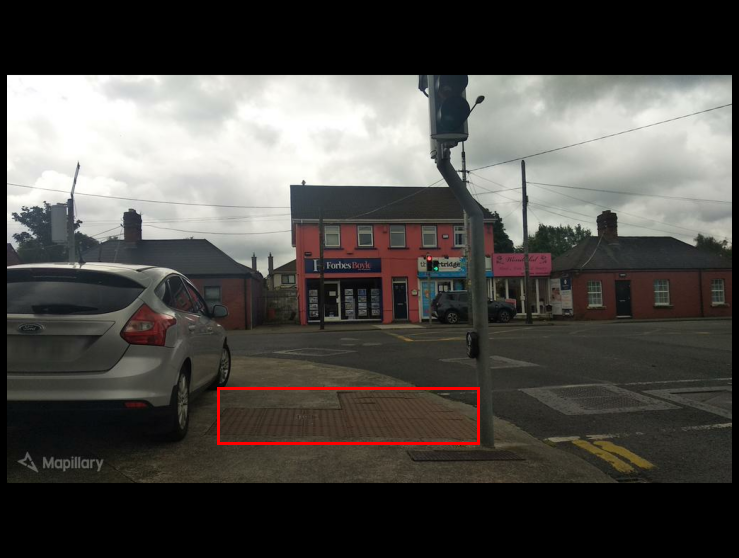

In [18]:
visualize_example(next(iter(ds.shuffle(16))))